In [1]:
import numpy as np
import pandas as pd
from scipy.stats import linregress
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
from datetime import datetime
%matplotlib inline


In [2]:
yield_data = pd.read_csv('FRB_H15.csv').replace('ND',np.nan).dropna(axis=0,how='any')
yield_data['Time Period'] = pd.to_datetime(yield_data['Time Period'])
yield_data['Day of week'] = yield_data['Time Period'].dt.dayofweek
#derive is weekend
yield_data['IS_WEEKEND'] = 1
weekend = yield_data['IS_WEEKEND'].copy()
weekend[(yield_data['Day of week'] != 5) & (yield_data['Day of week'] != 6)] = 0
yield_data['IS_WEEKEND'] = weekend
yield_data.set_index('Time Period',inplace=True)
yield_data.index.name = None
#kickout weekend data
yield_data=yield_data.query('IS_WEEKEND==0')
#cut off data 2010 onwards,but for rolling window of 30 we need '09 dec data
yield_data = yield_data[yield_data.index >'2001-07-31']


** Use [Savitzky–Golay filter](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) to smooth the series(get rid of peaks in Monday and Friday). I use rolling window of 15 and power of 3 **

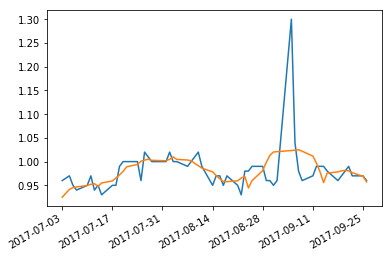

In [3]:
##savgol_filter polynomial filter
yield_data_filtered = pd.DataFrame(savgol_filter(np.array(yield_data.iloc[:,:11]).transpose(),15,3).transpose())
yield_data_filtered.columns = yield_data.iloc[:,:11].columns
yield_data_filtered.index = yield_data.index
yield_data_filtered.head()
yield_data[yield_data.index >'2017-07-01']['1-month'].astype(np.float32).plot()
yield_data_filtered[yield_data_filtered.index >'2017-07-01']['1-month'].astype(np.float32).plot()

**Define a rolling window function that calculate following statistic for one column:**  
1.Mean  
2.Standard Deviation  
3.Median  
4.Min  
5.Max  
6.Rooted Mean Square  
7.[Crest Factor](https://en.wikipedia.org/wiki/Crest_factor)  
8.[Zero-crossing Rate](https://en.wikipedia.org/wiki/Zero-crossing_rate)(here is Mean-crossing Rate)  
9.Trend(Slope of linear regression)

In [4]:
def rolling_method(df,col,window):
    method = ['mean','std','median','min','max']
    a = df[col].rolling(window=window)
    b = pd.concat([getattr(a,k)() for k in method],axis=1)
    b.columns  = method
    #b['RMS'] = a.apply(lambda y: np.sqrt(np.mean(y**2)))
    #b['crest'] = 0.5*(b['max']-b['min'])/b['RMS']
    #b['crossing'] = a.apply(lambda y: len(np.where(np.diff(y - np.mean(y)))[0]))/window
    #b['slope'] = a.apply(lambda y: linregress(range(window),y)[0])
    b.columns = [col + '_'+ k +'_'+str(window)+'day' 
                 for k in ['mean','std','median','min','max'#,'RMS','crest','crossing','slope'
                          ]]
    return b

In [5]:
yield_data_features=pd.concat([rolling_method(yield_data_filtered,i,j) \
                               for i in yield_data_filtered.columns[:11] \
                               for j in [3,7,15,20]],axis=1).shift(11) 
# 11 beacuse first shift 1 and then shift 10 as rolling window of 20 from 10th to 30th day
yield_data_features.head(10)


,1-month_mean_3day,1-month_std_3day,1-month_median_3day,1-month_min_3day,1-month_max_3day,1-month_mean_7day,1-month_std_7day,1-month_median_7day,1-month_min_7day,1-month_max_7day,...,30-year_mean_15day,30-year_std_15day,30-year_median_15day,30-year_min_15day,30-year_max_15day,30-year_mean_20day,30-year_std_20day,30-year_median_20day,30-year_min_20day,30-year_max_20day
2001-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-08-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


** Append the actual yield values and apply lag **

In [6]:
yield_data_features=pd.concat([yield_data_features,yield_data],axis=1)
#yield_data_features.dropna(axis=0,how='any',inplace=True)
yield_data_features.head()
for i in range(1,11):
    temp=yield_data_features[[col for col in yield_data_filtered.columns]].shift(i)
    temp.columns=[j+'_'+str(i) for j in list(temp.columns)]
    yield_data_features=pd.concat([yield_data_features,temp],axis=1)
yield_data_features.dropna(axis=0,how='any',inplace=True)
yield_data_features.head()

,1-month_mean_3day,1-month_std_3day,1-month_median_3day,1-month_min_3day,1-month_max_3day,1-month_mean_7day,1-month_std_7day,1-month_median_7day,1-month_min_7day,1-month_max_7day,...,3-month_10,6-month_10,1-year_10,2-year_10,3-year_10,5-year_10,7-year_10,10-year_10,20-year_10,30-year_10
2001-09-17,3.479041,0.000581,3.479348,3.478371,3.479403,3.480346,0.002754,3.479403,3.476507,3.483919,...,3.42,3.33,3.44,3.67,3.92,4.43,4.67,4.78,5.44,5.36
2001-09-18,3.477400,0.003422,3.479348,3.473448,3.479403,3.479910,0.003583,3.479403,3.473448,3.483919,...,3.36,3.28,3.38,3.61,3.88,4.42,4.68,4.79,5.45,5.37
2001-09-19,3.488839,0.021748,3.479348,3.473448,3.513719,3.484566,0.013335,3.479403,3.473448,3.513719,...,3.37,3.31,3.41,3.64,3.91,4.46,4.72,4.85,5.47,5.39
2001-09-20,3.503526,0.026496,3.513719,3.473448,3.523412,3.490208,0.019802,3.479403,3.473448,3.523412,...,3.44,3.43,3.55,3.83,4.1,4.63,4.88,4.99,5.59,5.5
2001-09-21,3.509342,0.016694,3.513719,3.490896,3.523412,3.491228,0.019597,3.479403,3.473448,3.523412,...,3.41,3.39,3.47,3.79,4.07,4.61,4.86,4.97,5.57,5.48


## feature importances plot

In [14]:
def feature_importances(target):
    print("******feature importances:",target,"*******")
    Y=yield_data_features[[target]]
    X=yield_data_features.drop(target,axis=1)
    X_train=X[X.index < '2017-07-01']
    X_test=X[X.index >= '2017-07-01']
    y_train=Y[Y.index < '2017-07-01']
    y_test=Y[Y.index  >= '2017-07-01']
    max_depth = 30
    regr_rf = RandomForestRegressor(max_depth=max_depth, random_state=2)
    regr_rf.fit(X_train, y_train)

    features = X.columns
    importances = regr_rf.feature_importances_
    indices = np.argsort(importances)[-10:][::-1]

    plt.title(f'Feature Importances for {target}')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features[indices]) ## removed [indices]
    plt.xlabel('Relative Importance')
    plt.show()

******feature importances: 1-month *******


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


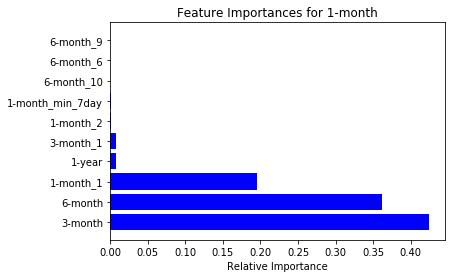

******feature importances: 3-month *******


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


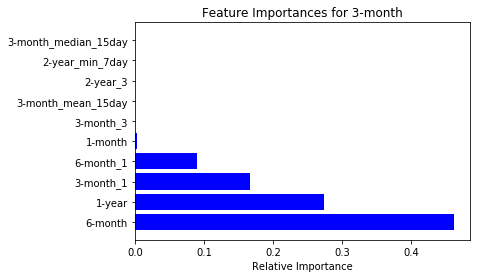

******feature importances: 6-month *******


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


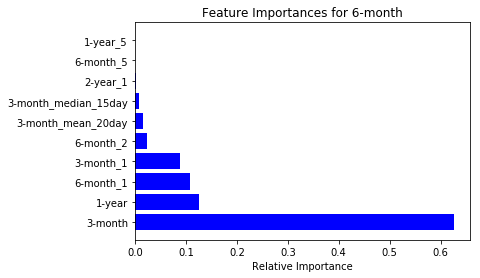

******feature importances: 1-year *******


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


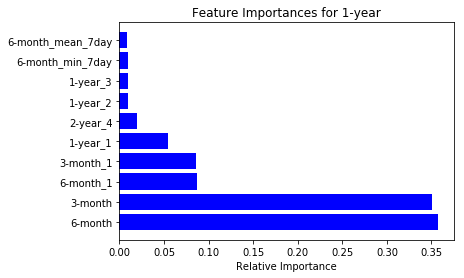

******feature importances: 2-year *******


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


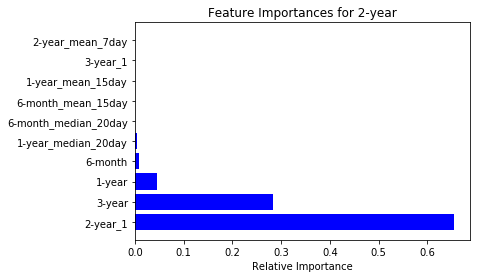

******feature importances: 3-year *******


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


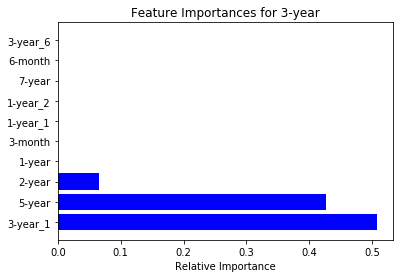

******feature importances: 5-year *******


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


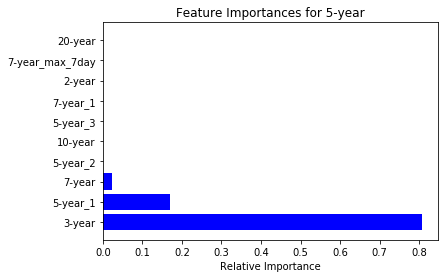

******feature importances: 7-year *******


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


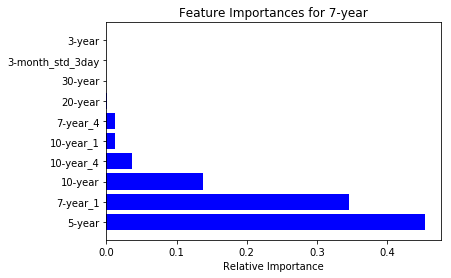

******feature importances: 10-year *******


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


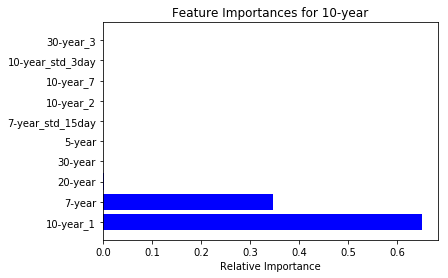

******feature importances: 20-year *******


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


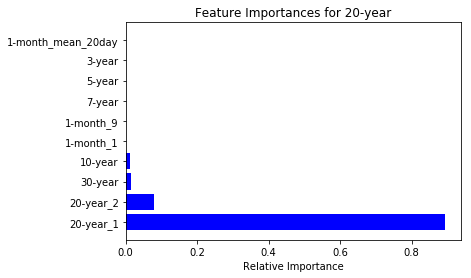

******feature importances: 30-year *******


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


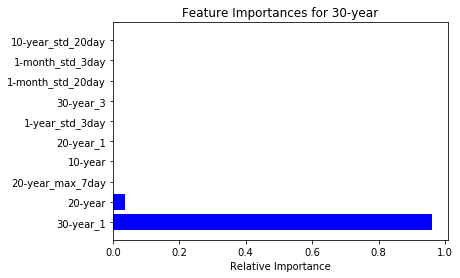

In [15]:
for target in ['1-month', '3-month', '6-month', '1-year', '2-year', '3-year', '5-year','7-year', '10-year', '20-year', '30-year']:
    feature_importances(target)
    